### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

# Foreword

If at any point during this sample notebook you receive a `ConfigFileNotFound` error then you just need to follow the necessary help pages for the OCI Python SDK ([here](https://docs.oracle.com/en-us/iaas/Content/API/Concepts/sdkconfig.htm) and [here](https://docs.oracle.com/en-us/iaas/Content/API/Concepts/apisigningkey.htm#apisigningkey_topic_How_to_Generate_an_API_Signing_Key_Console)) to create the config and pem files and place them in the necessary directory (`~/.oci/`).

# Training SVM to Classify Handwritten Digits

In this example we're training a Support Vector Machine from scikit-learn's library to classify images of handwritten digits.

In [13]:
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# Load dataset
digits = datasets.load_digits()

# Flatten images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create Support Vector Machine
clf = svm.SVC(gamma=0.001)

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# Train the SVM
clf.fit(X_train, y_train)

# Evaluate model on test set
predicted = clf.predict(X_test)

Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      0.97      0.98        91
           2       0.99      0.99      0.99        86
           3       0.98      0.87      0.92        91
           4       0.99      0.96      0.97        92
           5       0.95      0.97      0.96        91
           6       0.99      0.99      0.99        91
           7       0.96      0.99      0.97        89
           8       0.94      1.00      0.97        88
           9       0.93      0.98      0.95        92

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899




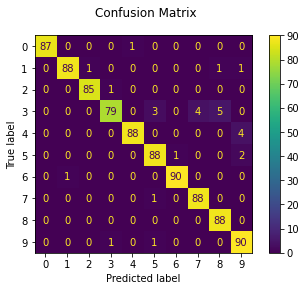

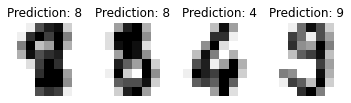

In [14]:
# Print classification report
print(f"Classification report for classifier {clf}:\n"
      f"{metrics.classification_report(y_test, predicted)}\n")

# Display confusion matrix
metrics.plot_confusion_matrix(clf, X_test, y_test)
plt.suptitle("Confusion Matrix")
plt.show()

# Display sample digits and their classifications
_, axes = plt.subplots(nrows=1, ncols=4)
for ax, image, prediction in zip(axes, X_test, predicted):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r)
    ax.set_title(f'Prediction: {prediction}')

# Creating Model Artifact

We can now move on to creating a model artifact, this saves your trained model to the cloud from which you can deploy your API.

In [15]:
import os
from ads.common.model_artifact import ModelArtifact
from ads.common.model_export_util import prepare_generic_model
from joblib import dump

# Create model artifact directory
path_to_artifact = f"./svm-digit-classifier"
if not os.path.exists(path_to_artifact):
    os.mkdir(path_to_artifact)
    
# Create artifact object
artifact = prepare_generic_model(path_to_artifact, function_artifacts=False, force_overwrite=True, data_science_env=True)
dump(clf, os.path.join(path_to_artifact, "svm.joblib"))

INFO:ADS:We give you the option to specify a different inference conda environment for model deployment purposes. By default it is assumed to be the same as the conda environment used to train the model. If you wish to specify a different environment for inference purposes, please assign the path of a published or data science conda environment to the optional parameter `inference_conda_env`. 


['./svm-digit-classifier/svm.joblib']

In [16]:
%%writefile {path_to_artifact}/score.py

import json
import os
from joblib import load
import pandas as pd
import io
import logging 
import sys

# logging configuration - OPTIONAL 
# Logging to stdout is required for the logs to appear in OCI Console
logging.basicConfig(stream=sys.stdout, format='%(name)s - %(levelname)s - %(message)s', level=logging.INFO)
logger_pred = logging.getLogger('model-prediction')
logger_pred.setLevel(logging.INFO)
logger_feat = logging.getLogger('input-features')
logger_feat.setLevel(logging.INFO)

"""
   Inference script. This script is used for prediction by scoring server when schema is known.
"""


def load_model():
    """
    Loads model from the serialized format

    Returns
    -------
    model:  a model instance on which predict API can be invoked
    """
    model_dir = os.path.dirname(os.path.realpath(__file__))
    contents = os.listdir(model_dir)
    model_file_name = "svm.joblib"
    # TODO: Load the model from the model_dir using the appropriate loader
    # Below is a sample code to load a model file using `cloudpickle` which was serialized using `cloudpickle`
    # from cloudpickle import cloudpickle
    if model_file_name in contents:
        with open(os.path.join(os.path.dirname(os.path.realpath(__file__)), model_file_name), "rb") as file:
            model = load(file) # Use the loader corresponding to your model file.
    else:
        raise Exception('{0} is not found in model directory {1}'.format(model_file_name, model_dir))
    
    return model


def predict(data, model=load_model()) -> dict:
    """
    Returns prediction given the model and data to predict

    Parameters
    ----------
    model: Model instance returned by load_model API
    data: Data format as expected by the predict API of the core estimator. For eg. in case of sckit models it could be numpy array/List of list/Panda DataFrame

    Returns
    -------
    predictions: Output from scoring server
        Format: { 'prediction': output from `model.predict` method }

    """
    assert model is not None, "Model is not loaded"
    X = pd.read_json(io.StringIO(data)) if isinstance(data, str) else pd.DataFrame.from_dict(data)
    preds = model.predict(X).tolist()
    # to logging service: 
    logger_pred.info(preds)
    logger_feat.info(X)
    return { 'prediction': preds }

Overwriting ./svm-digit-classifier/score.py


# Saving Model Artifact to Model Catalogue

In [17]:
# Get test data
input_data = pd.DataFrame(X_test[:5])
input_data_json = input_data.to_json()

# Capturing a sample payload file for testing the Function in production: 
with open(os.path.join(path_to_artifact, "sample-payload.json"),'w') as f:
    json.dump(input_data_json, f)
    
# Saving the model artifact to the model catalog.
compartment_id = os.environ['NB_SESSION_COMPARTMENT_OCID']
project_id = os.environ["PROJECT_OCID"]

catalog_entry = artifact.save(
    project_id=project_id,
    compartment_id=compartment_id,
    display_name='sklearn-digit-recognition-1', 
    description='SVM trained to recognise handwritten digits.',
    training_script_path='',
    ignore_pending_changes=True
)

INFO:ADS:{
  "git_branch": "None",
  "git_commit": "None",
  "repository_url": "None",
  "script_dir": "/home/datascience/svm-digit-classifier",
  "training_script": "CAN_BE_INVALID:/home/datascience"
}


# Deploying the Model

Deploying the model from this point on is most intuitively done from the OCI console. Please proceed to the Data Science Project you created for this notebook, go to the 'Models' tab displayed on the left, and select the 'sklearn-digit-recognition-1' model we've just created. From there it's as simple as pressing the 'Create Deployment' button and you're done! We can now move on to invoking your model.

# Making Classification Requests to Your Model Endpoint

On your model deployment page in the OCI console, go to the 'Invoking Your Model' page and copy the model HTTP endpoint.

In [52]:
import os
import requests
import oci
from oci.signer import Signer

uri = 'your-uri-here'
print(uri)

your-uri-here


In [50]:
%%time 

# using resource principals. You can alternatively use the config+key flow. 

# Using Resource principal to authenticate against the model endpoint. Set using_rps=False if you are using 
# the config+key flow. 
using_rps = False
endpoint = uri

# payload: 
input_data = pd.DataFrame(X_test[0:10]).to_json()
body = input_data

if using_rps: # using resource principal:     
    auth = oci.auth.signers.get_resource_principals_signer()
else: # using config + key: 
    config = oci.config.from_file("~/.oci/config") # replace with the location of your oci config file
    auth = Signer(
        tenancy=config['tenancy'],
        user=config['user'],
        fingerprint=config['fingerprint'],
        private_key_file_location=config['key_file'],
        pass_phrase=config['pass_phrase'])
    
# submit request to model endpoint:
response = requests.post(endpoint, json=input_data, auth=auth).json()
print(response)

{'prediction': [8, 8, 4, 9, 0, 8, 9, 8, 1, 2]}
CPU times: user 39.2 ms, sys: 5.36 ms, total: 44.5 ms
Wall time: 346 ms


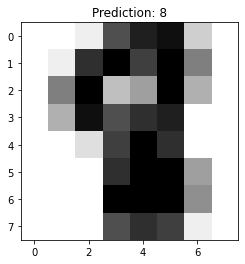

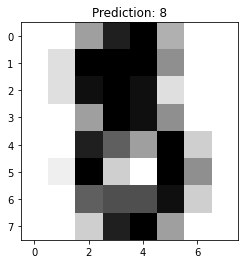

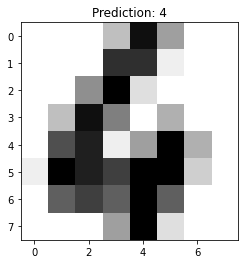

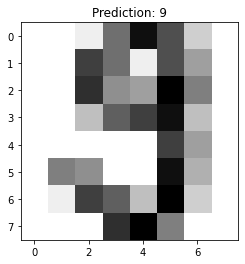

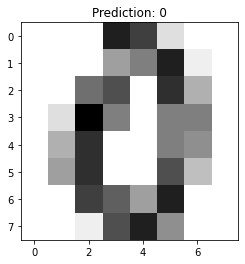

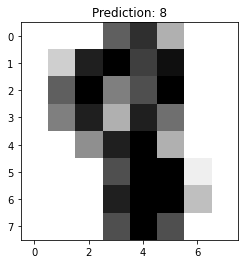

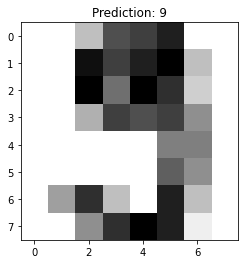

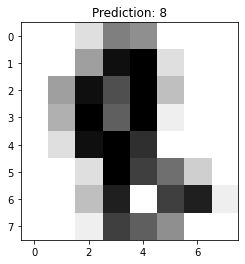

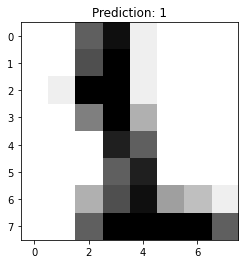

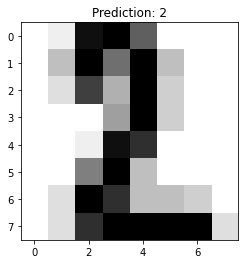

In [51]:
# Display sample digits and their classifications
for image, prediction in zip(X_test, response['prediction']):
    image = image.reshape(8, 8)
    plt.imshow(image, cmap=plt.cm.gray_r)
    plt.title(f'Prediction: {prediction}')
    plt.show()